In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_7_1_adaptation_smaller_'

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import dill
from IPython.display import clear_output


from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# print(mpl.rcParams.keys())


In [5]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.01 # -> 10us

# Solve differential equation from time 0 to time T
T = 400.0 # -> 4000ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 3.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0
############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 2500
alpha_p = 25.0
beta_p = 25.0

In [6]:
############################################################
#                       Functions                          #
############################################################



#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.minimum(np.maximum(q_pc,0),1)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # default gaba inhibiton
    gaba_inh -= 0.01
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = convolve1d(s_sbc,weights=ee_kernel,axis=0,mode='reflect')*(1-gaba_exc)
    # calculate inhibitor input, which comes from the q_pc folded by the E-I kernel
    inhibitory_in = convolve1d(g_q_out(q_pc),weights=ei_kernel,axis=0,mode='reflect')*(1-gaba_inh)     
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = convolve1d(s_gbc,weights=ie_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = convolve1d(g_q_out(q_pc_all),weights=ii_kernel,axis=0,mode='reflect')     
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p



# Input

In [7]:

# GABA parameter
sbc_input_intensities = np.linspace(1.0,0.0,41)
gbc_input_intensities = np.linspace(0.0,1.0,41)

adaptor_tone =np.linspace(0.25,-0.25,41)


# store values for different parameters
q_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(adaptor_tone), len(gbc_input_intensities),len(t),freq_bands))

gaba_inh_values = np.zeros((len(t),freq_bands))
gaba_exc_values = np.zeros((len(t),freq_bands))


############################################################
#                      Simulation                          #
############################################################


sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)

gauss_mask = gauss(np.linspace(-50,50,10000),0,1)
gauss_mask = gauss_mask/gauss_mask.sum()

for l in range(len(adaptor_tone)):
    for k in range(len(sbc_input_intensities)):

        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 1.0

        ### MNTB inhibitory input (contra-lateral) ###
        gbc_center_frequencyBand =2
        gbc_input_strength = gbc_input_intensities[k]
            
        # build ramps
        onset = 4000
        s_gbc_all[onset:onset+12000,:] = 0.5+adaptor_tone[l] 
        s_gbc_all[21000:,:] = 1 * gbc_input_strength


#         # create a linearly decreasing function in frequency band 'center_frequencyband'
#         # and smear it with a gauss to effect the neighboring bands
#         gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
#         s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')

        
        

        # LSO direct excitatory input (ipsi-lateral)
        sbc_center_frequencyBand = 2
        sbc_input_strength = sbc_input_intensities[k]
        onset = 4000
        s_sbc_all[onset:onset+12000,:] = 0.5-adaptor_tone[l]
        s_sbc_all[21000:,:] = 1 * sbc_input_strength


#         # create a linearly decreasing function in frequency band 'center_frequencyband'
#         # and smear it with a gauss to effect the neighboring bands
#         sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
#         s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


        s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask,axis=0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask,axis=0,mode='constant')

        # correct for border effect of convolve
        s_gbc_all[-2500:,:] = np.max(s_gbc_all[-2500:])
        s_sbc_all[:2500,:] = np.max(s_sbc_all[:2500])





        for i in range(0, len(t)-1):

            gaba_inh_values[i,:] =   p_all[l,k,i,:]*1
            gaba_exc_values[i,:] =   p_all[l,k,i,:]*1.25

            r_all[l,k,i+1,:] = r_all[l,k,i,:] +  dt * ode_r_bpc(r_all[l,k,i,:],s_sbc_all[i],ee_kernel,q_all[l,k,i,:],ei_kernel,gaba_exc_values[i,:],gaba_inh_values[i,:])       
            q_all[l,k,i+1,:] = q_all[l,k,i,:] +  dt * ode_q_pc(q_all[l,k,i,:],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

            p_all[l,k,i+1,:] = p_all[l,k,i,:] + dt * ode_p_pc(p_all[l,k,i,:],g_r_out(r_all[l,k,i,:]))
        clear_output(wait=True)
        print(l,k)




40 40


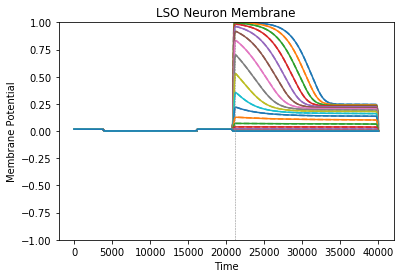

In [9]:
# Define the times when to probe
probing_time = 21150
# show LSO neuron membrane
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]
fig = plt.figure()
ax2 = fig.add_subplot(111)
for j in range(0,len(adaptor_tone)):
    if adaptor_tone[j] == 0:
        line_style = '-'
    elif adaptor_tone[j] == 0.25:
        line_style = '--'
    elif adaptor_tone[j] == 0.5:
        line_style = ':'
    else:
        line_style = ''

    for i in range(0,r.shape[1]):
#         plt.plot(p[j,i,:],linestyle=line_style)
        plt.plot(g_r_out(r[j,i,:]),linestyle=line_style)
        
plt.axvline(x=probing_time,linestyle='--',color='grey',linewidth=0.5)
plt.title('LSO Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1])
plt.show()

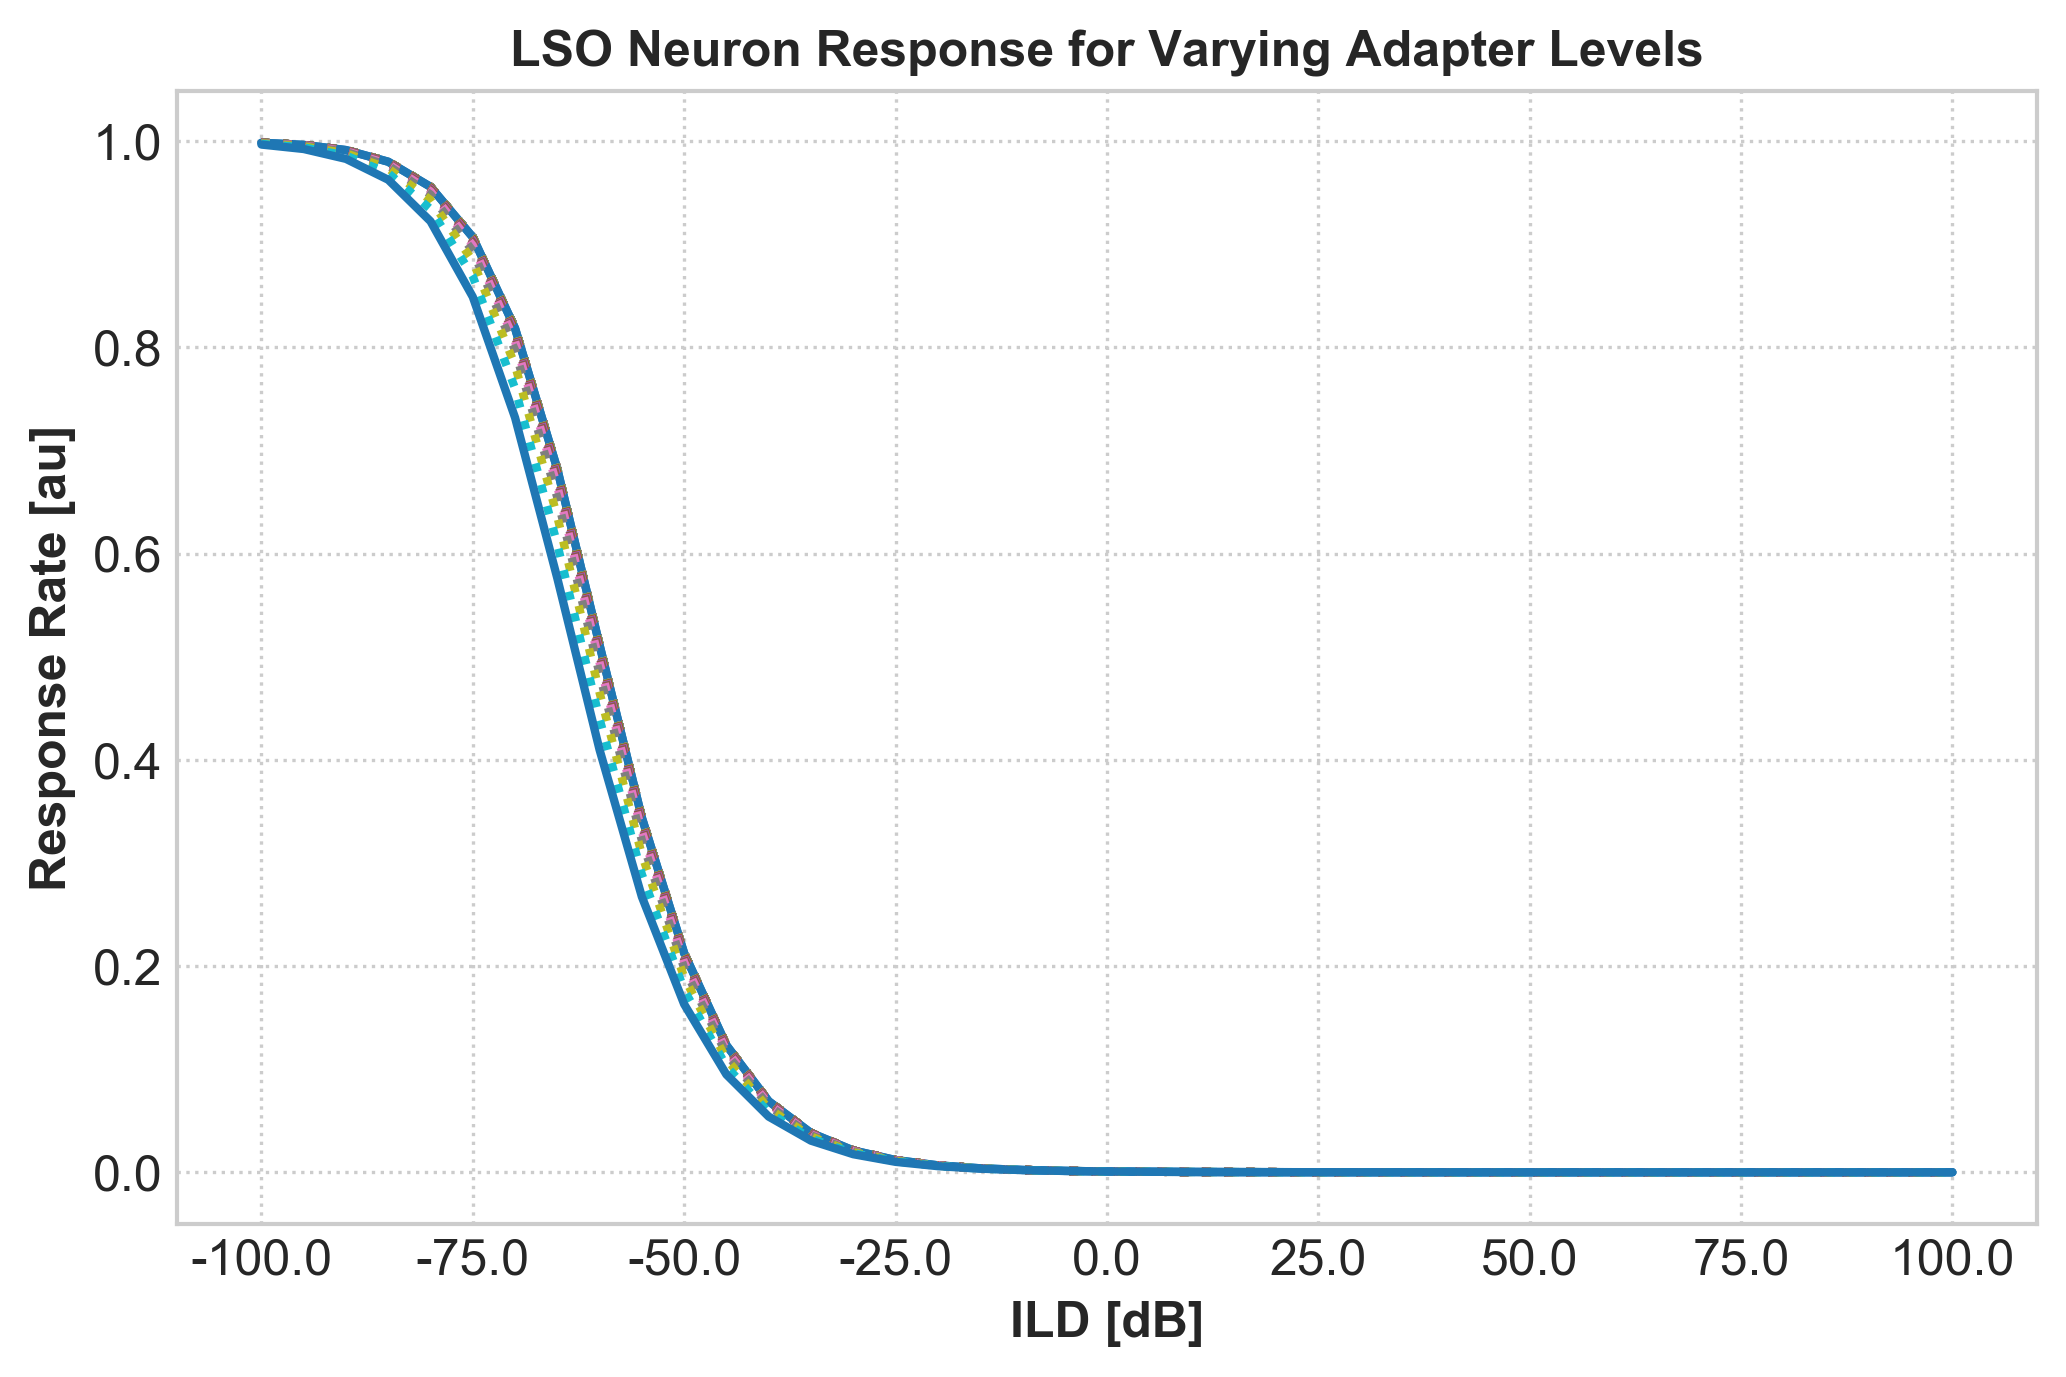

In [23]:
# Define the times when to probe
# probing_times = [2350]
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
for j in np.arange(0,len(adaptor_tone)):
    if j == 0 or j == len(adaptor_tone)-1 or adaptor_tone[j] == 0:
        line_style = '-'
    else:
        line_style = ':'
    
      
    tmp = g_r_out(r[j,:,probing_time])
    diff = gbc_input_intensities-sbc_input_intensities
    ax2.plot(diff,tmp,linestyle=line_style,label='Adapter Intensity : {0:.2f}'.format(adaptor_tone[j]))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
# ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels([ round(k * 100) for k in ax2.get_xticks()])

# lgd = plt.legend()

# plt.savefig(figure_name + 'response_shift.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'response_shift.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




0.0
0.0
0.0


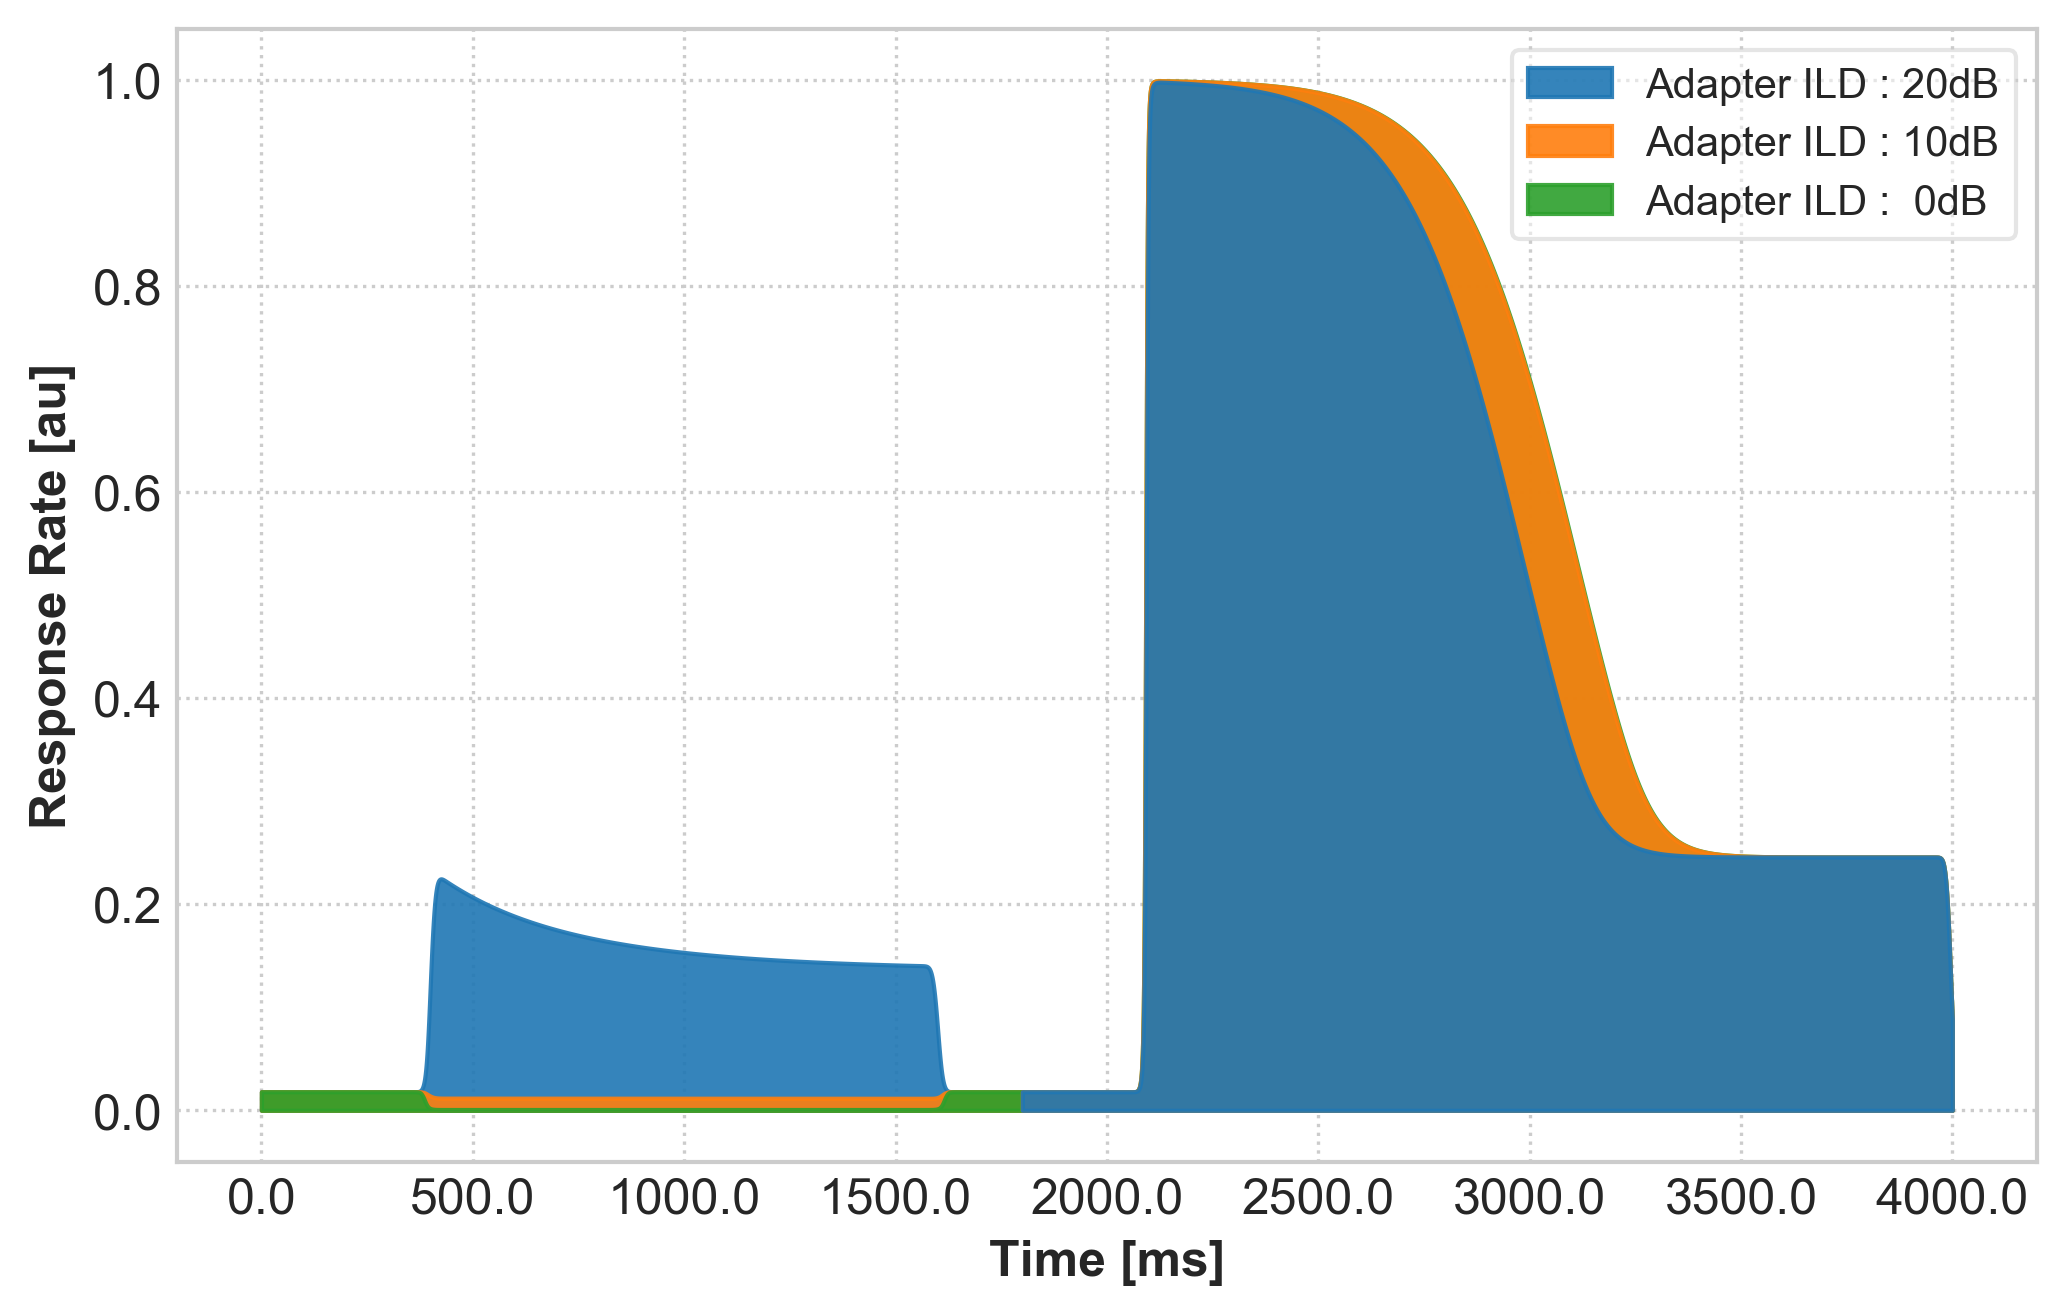

In [24]:

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure()


plotting_range = np.arange(0,18000)
## show LSO neuron response
ax2 = fig.add_subplot(111)
l = 0
# adaptor_levels = [7,int(r.shape[0]/2)+4,r.shape[0]-4]
# adaptor_levels = [10,int(r.shape[0]/2)+5,r.shape[0]-1]
# adaptor_levels = [r.shape[0]-1,int(r.shape[0]/2)+5,10]
adaptor_levels = [r.shape[0]-1,int(r.shape[0]/2)+10,int(r.shape[0]/2)+0]
# print(adaptor_tone[adaptor_levels])
# adaptor_levels = range(0,r.shape[0])
for j in adaptor_levels:
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'

    l +=1
    for i in range(0,1):
        tmp = g_r_out(r[j,i,:])
        print(gbc_input_intensities[i])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color,label='Level Difference = {0:.1f}'.format(sbc_input_intensities[i]-gbc_input_intensities[i]))
        
        if adaptor_tone[j] == 0:
            ax2.fill_between(t[plotting_range]*10,tmp[plotting_range], 0, color = face_color, alpha=0.9,label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[j]*200))
        else:
            ax2.fill_between(t[plotting_range]*10,tmp[plotting_range], 0, color = face_color, alpha=0.9,label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[j]*-80))
#         if adaptor_tone[j] == 0:
#             ax2.plot(t[plotting_range]*1000,tmp[plotting_range], color = face_color, alpha=0.9,label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[j]*200))
#         else:
#             ax2.plot(t[plotting_range]*1000,tmp[plotting_range], color = face_color, alpha=0.9,label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[j]*-200))


plotting_range = np.arange(18000,40000)
## show LSO neuron response
for j in adaptor_levels[::-1]:
    l -=1
    if l == 0 :
        line_style = '-'
        line_color = 'C0'
        face_color = 'C0'
    elif l == 1:
        line_style = '-'
        line_color = 'C1'
        face_color = 'C1'

    else:
        line_style = '-'
        line_color = 'C2'
        face_color = 'C2'



    for i in range(0,1):
        tmp = g_r_out(r[j,i,:])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range],linestyle=line_style,color=line_color)
        ax2.fill_between(t[plotting_range]*10,tmp[plotting_range], 0, color = face_color,  alpha=0.9)
#         ax2.plot(t[plotting_range]*1000,tmp[plotting_range], color = face_color,  alpha=0.9)
        
        
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
# plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.ylabel('Response Rate [au]')
plt.xlabel('Time [ms]')
ax2.set_xticklabels(ax2.get_xticks())
ax2.invert_xaxis()
lgd = plt.legend()

# ax2.vlines(211000,0,1)

# plt.savefig(figure_name + 'membrane_adapter.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'membrane_adapter.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
# plt.savefig(figure_name + 'membrane_adapter.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




0.0


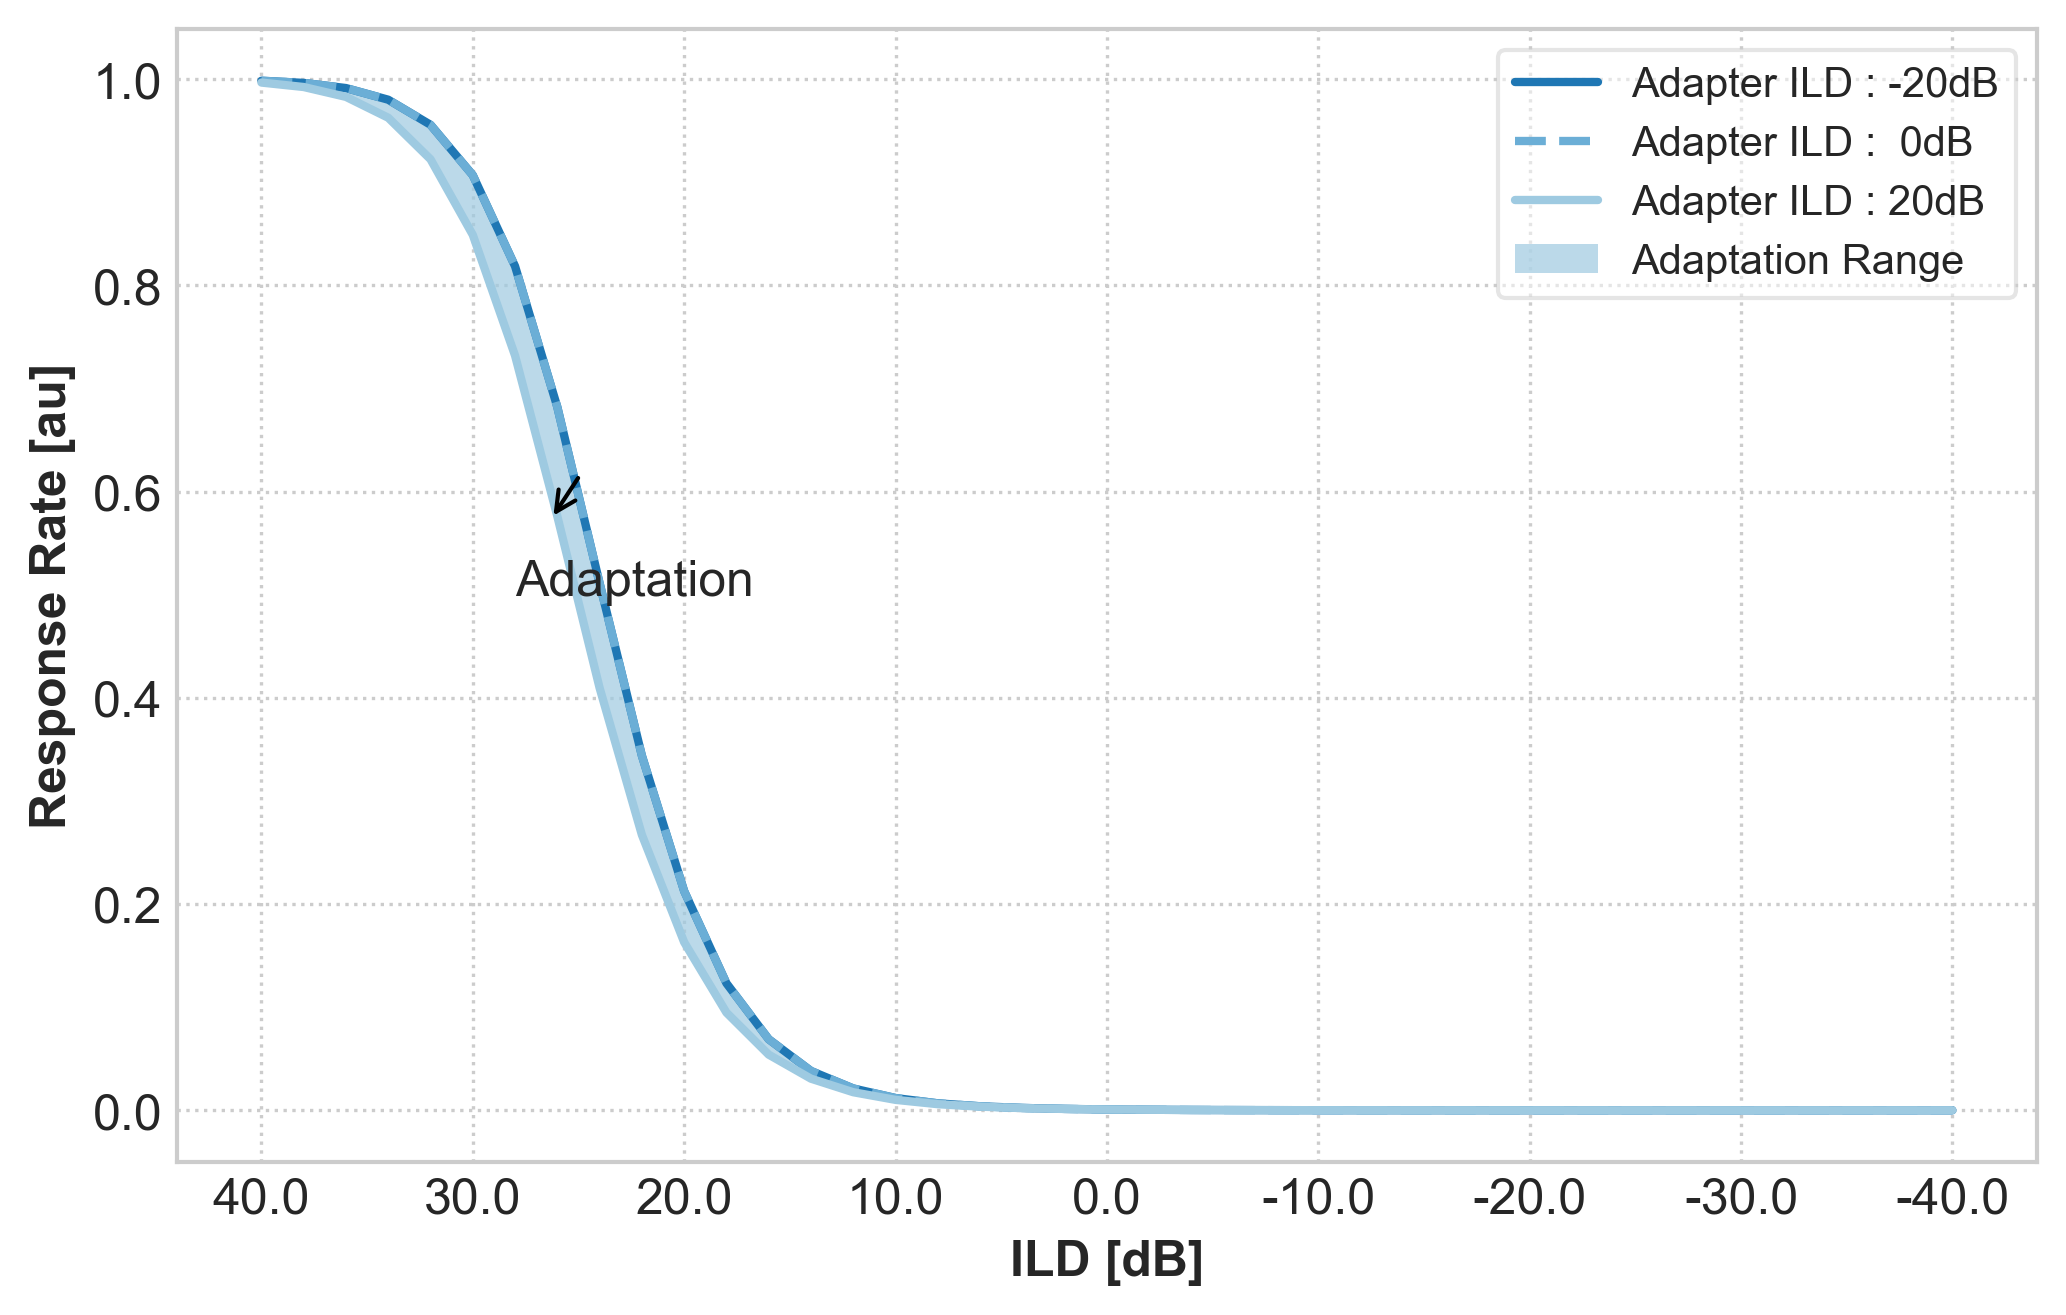

In [25]:
# Define the times when to probe
# probing_times = [2450]

fig = plt.figure()


diff = gbc_input_intensities-sbc_input_intensities

r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
p = p_all[:,:,:,sbc_center_frequencyBand]

## show LSO neuron response
ax2 = fig.add_subplot(111)
print(adaptor_tone[20])

# tmp = g_r_out(r[20,:,probing])
# ax2.plot(-diff,tmp,linestyle='-',label='Adapter Intensity : {0:2.0f}dB'.format(adaptor_tone[20]*100))



tmp = np.squeeze(g_r_out(r[0,:,probing_time]))
ax2.plot(-diff,tmp,linestyle='-',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[0]*-80))

tmp1 = np.squeeze(g_r_out(r[20,:,probing_time]))
ax2.plot(-diff,tmp1,linestyle='--',color='#6baed6',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[20]*200))

tmp2 = np.squeeze(g_r_out(r[-1,:,probing_time]))
ax2.plot(-diff,tmp2,linestyle='-',color='#9ecae1',label='Adapter ILD : {0:2.0f}dB'.format(adaptor_tone[-1]*-80))

ax2.fill_between(-diff,tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Adaptation Range')

# ax2.annotate("", xy=(0.90, 0.5), xytext=(0.45, 0.5),arrowprops=dict(arrowstyle="<->",linewidth=3))
# ax2.annotate("", xy=(1, 1), xytext=(1, 0.71),arrowprops=dict(arrowstyle="<->",linewidth=3))

ax2.annotate("", xy=(0.62, 0.62), xytext=(0.66, 0.57),arrowprops=dict(arrowstyle="<-",linewidth=1))
ax2.annotate("Adaptation", xy=(0.50, 0.45), xytext=(0.70, 0.50))

# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
# plt.title('LSO Neuron Response for Varying Adapter Levels')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
lgd = plt.legend()

# plt.savefig(figure_name + 'response_shift_nicer.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'response_shift_nicer.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')
# plt.savefig(figure_name + 'response_shift_nicer.tiff', bbox_extra_artists=(lgd,),bbox_inches='tight')

plt.show()




(41,)


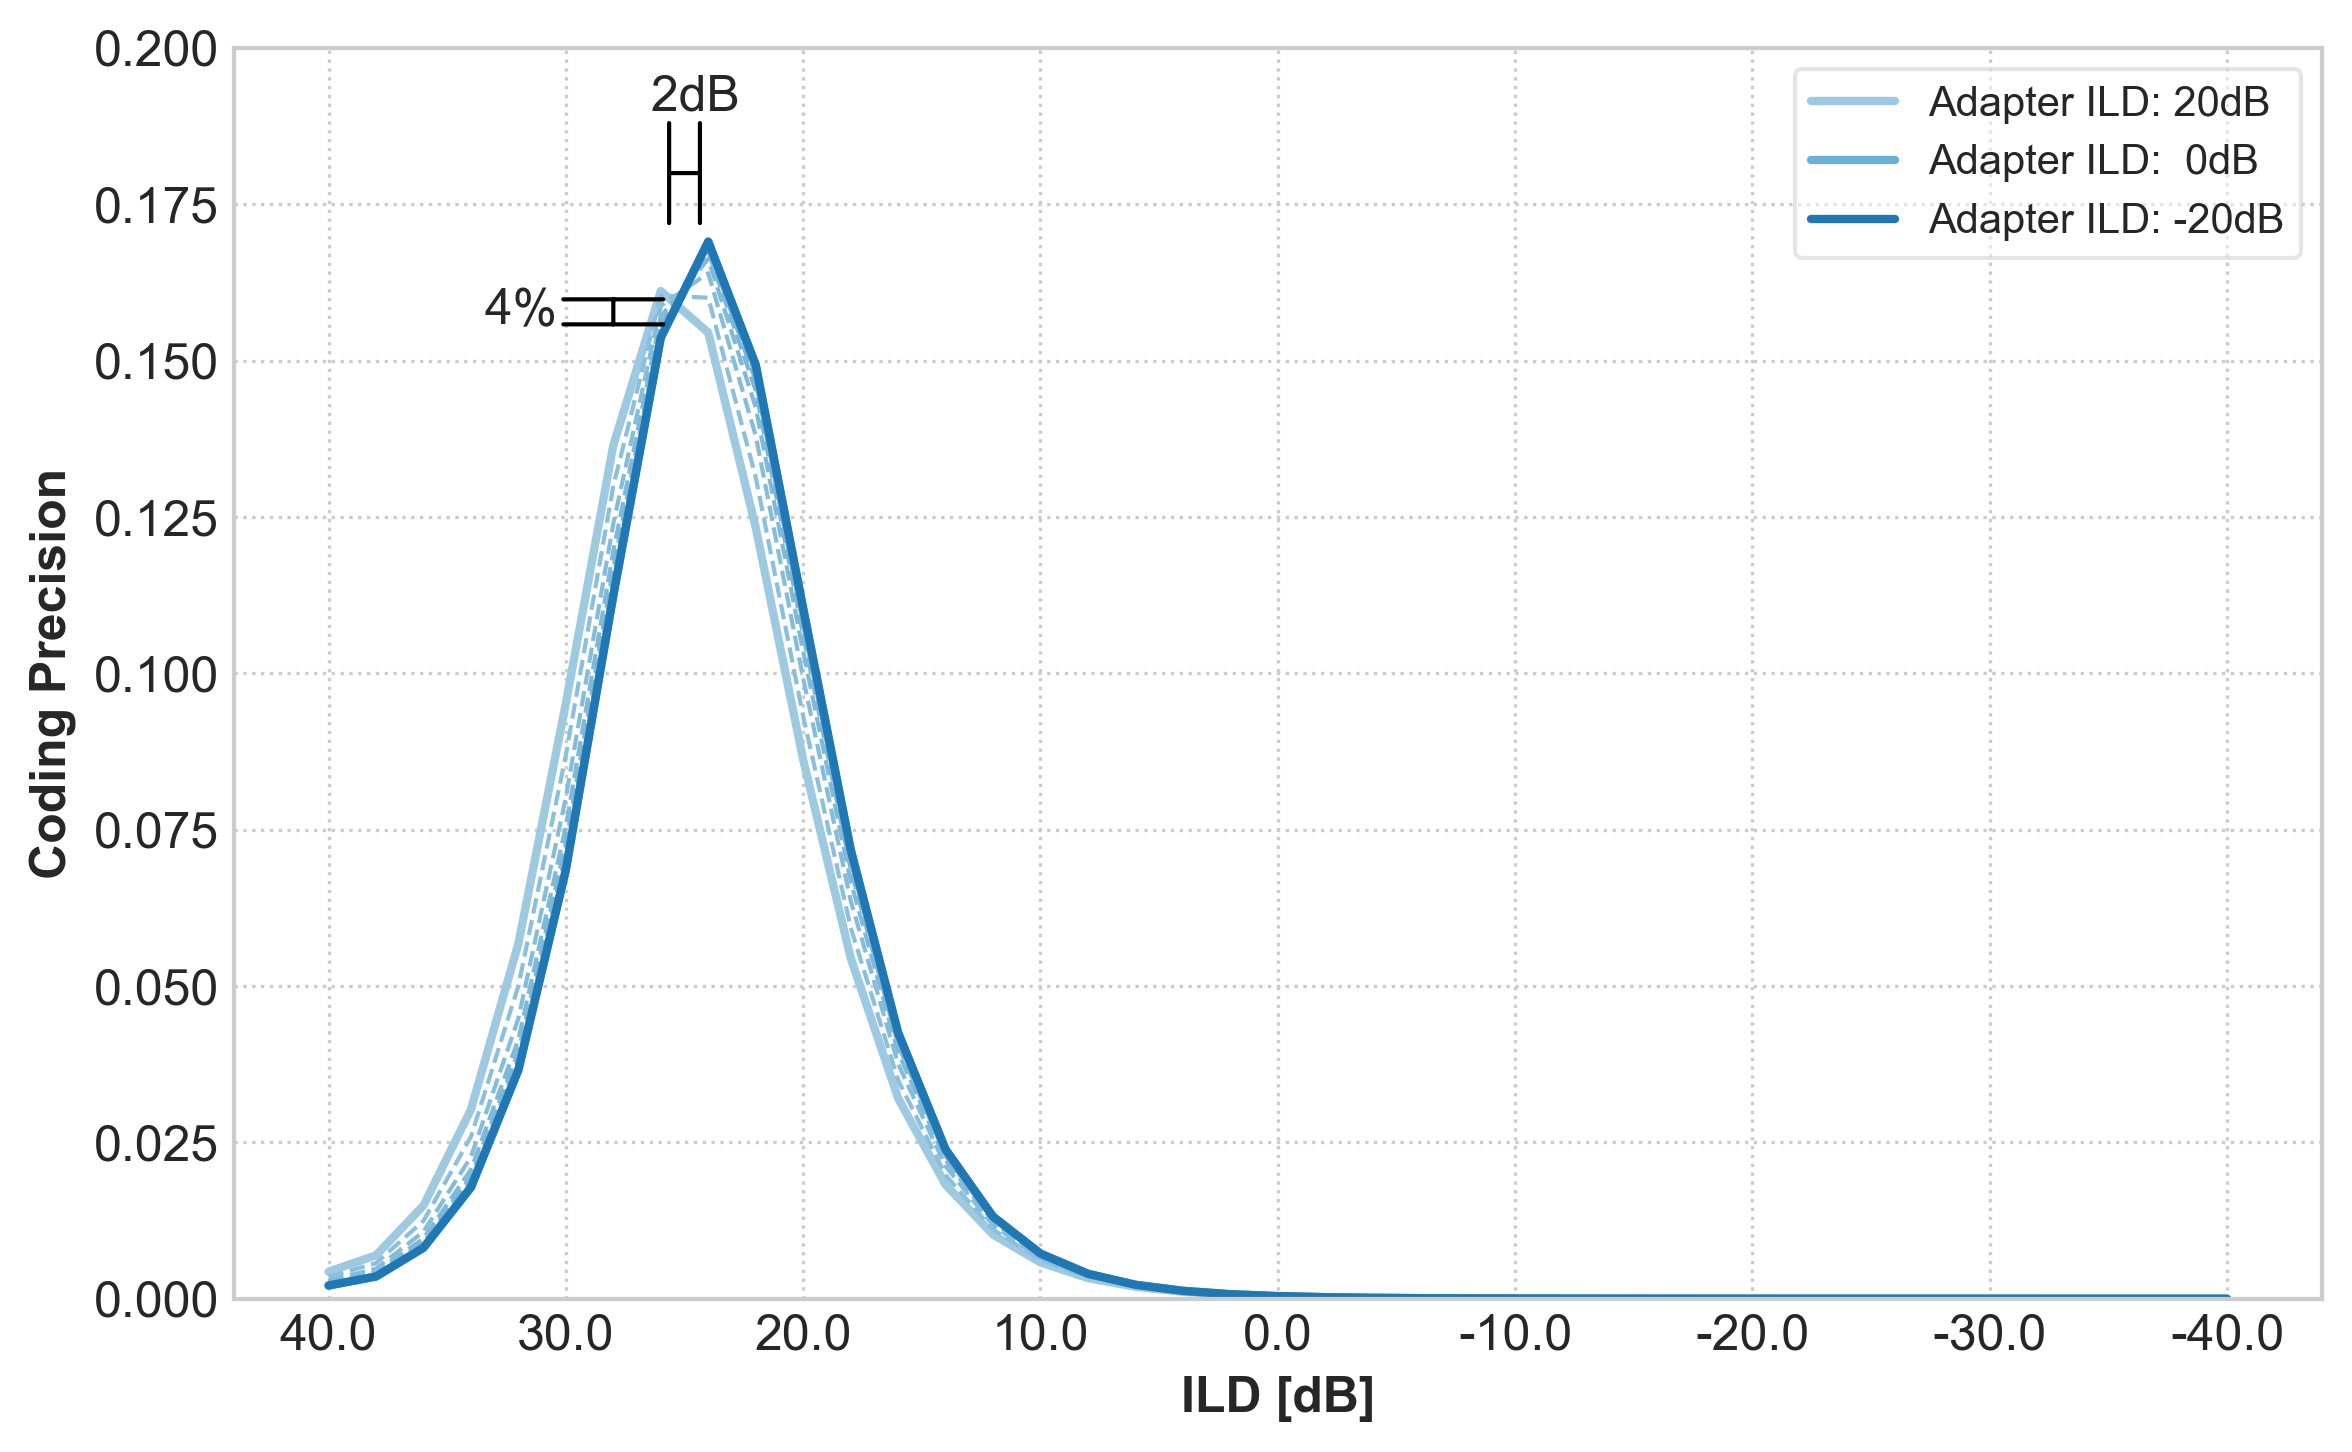

In [26]:
# fig = plt.figure()
# ax2 = fig.add_subplot(111)

## show LSO neuron response
# r = r_all[:,0::2,:,sbc_center_frequencyBand]
diff = gbc_input_intensities-sbc_input_intensities
# diff = diff[0::2]
print(diff.shape)
## show LSO neuron response
ilds = np.zeros((len(adaptor_tone),r.shape[1]))
## show LSO neuron response
for j in np.arange(0,len(adaptor_tone)):
    if j == 0 or j == len(adaptor_tone)-1:
        line_style = '-'
    else:
        line_style = ':'
    tmp = g_r_out(r[j,:,probing_time])
    ilds[j,:] = tmp



from mpltools import color

fig = plt.figure()

## show LSO neuron response
ax2 = fig.add_subplot(111)
colors = plt.cm.Blues(np.linspace(0.9,0.4,ilds.shape[1]))
ax2.set_prop_cycle('color', colors)




###########
# GRADIENT
###########
tmp2 = g_r_out(r[-1,:,probing_time])
ax2.plot(-diff,-np.gradient(tmp2),linestyle='-',color='#9ecae1',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[-1]*-80))

tmp =-np.array( np.gradient(ilds,axis=1))
ax2.plot(-diff,tmp.T[:,1:-1],linewidth = int(drawing_size/9),linestyle='--')

tmp = g_r_out(r[20,:,probing_time])
ax2.plot(-diff,-np.gradient(tmp),linestyle='-',color='#6baed6',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[20]*200))

tmp = g_r_out(r[0,:,probing_time])
ax2.plot(-diff,-np.gradient(tmp),linestyle='-',color='C0',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[0]*-80))




# calculate x value for first peak
x1 = diff[np.argmax(-np.gradient(tmp))]
x2 = diff[np.argmax(-np.gradient(tmp2))]
ax2.annotate("", xy=(-x2, 0.180), xytext=(-x1, 0.180),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=((x2-x1)/2 -x2+0.05, 0.0), xytext=((x2-x1)/2 -x2+0.05, 0.190))


y1 = np.max(-np.gradient(tmp2))
y1_ind = np.argmax(-np.gradient(tmp))
y2 = -np.gradient(tmp2)[y1_ind]

ax2.annotate("", xy=(0.7, y1), xytext=(0.7, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(0.8, y2+(y1-y2)/2), xytext=(0.85,  y2+(y1-y2)/2 -0.002))

l = [0]
l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
ax2.set_xticklabels(l)
ax2.set_ylabel('Coding Precision')
ax2.set_xlabel('ILD [dB]')
ax2.invert_xaxis()
ax2.set_ylim([0,0.20])
# ax2.legend(loc=(1.04,0))
ax2.legend()
# plt.title('Coding Precision')

plt.tight_layout()

# plt.savefig(figure_name + 'coding_prescision.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'coding_prescision.pdf', bbox_inches='tight')
# plt.savefig(figure_name + 'coding_prescision.pdf', bbox_inches='tight')

plt.show()



In [27]:
# # fig = plt.figure()
# # ax2 = fig.add_subplot(111)

# ## show LSO neuron response
# # r = r_all[:,0::2,:,sbc_center_frequencyBand]
# diff = gbc_input_intensities-sbc_input_intensities
# # diff = diff[0::2]
# print(diff.shape)
# ## show LSO neuron response
# ilds = np.zeros((len(adaptor_tone),r.shape[1]))
# ## show LSO neuron response
# for j in np.arange(0,len(adaptor_tone)):
#     if j == 0 or j == len(adaptor_tone)-1:
#         line_style = '-'
#     else:
#         line_style = ':'
#     tmp = g_r_out(r[j,:,probing_time])
#     ilds[j,:] = tmp



# from mpltools import color

# fig = plt.figure()

# ## show LSO neuron response
# ax2 = fig.add_subplot(111)
# colors = plt.cm.Blues(np.linspace(0.9,0.4,ilds.shape[1]))
# ax2.set_prop_cycle('color', colors)




# ###########
# # GRADIENT
# ###########
# tmp2 = g_r_out(r[-1,:,probing_time])
# ax2.plot(-diff,-np.gradient(tmp2)*(tmp2),linestyle='-',color='#9ecae1',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[-1]*-80))

# tmp =-np.array( np.gradient(ilds,axis=1))
# ax2.plot(-diff,(tmp*(ilds)).T[:,1:-1],linewidth = int(drawing_size/9),linestyle='--')

# tmp = g_r_out(r[20,:,probing_time])
# ax2.plot(-diff,-np.gradient(tmp)*(tmp),linestyle='-',color='#6baed6',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[20]*200))

# tmp = g_r_out(r[0,:,probing_time])
# ax2.plot(-diff,-np.gradient(tmp)*(tmp),linestyle='-',color='C0',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[0]*-80))




# # calculate x value for first peak
# x1 = diff[np.argmax(-np.gradient(tmp))]
# x2 = diff[np.argmax(-np.gradient(tmp2))]
# ax2.annotate("", xy=(-x2, 0.125), xytext=(-x1, 0.125),arrowprops=dict(arrowstyle="|-|",linewidth=1))
# ax2.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=((x2-x1)/2 -x2+0.05, 0.135), xytext=((x2-x1)/2 -x2+0.05, 0.135))


# y1 = np.max(-np.gradient(tmp2))
# y1_ind = np.argmax(-np.gradient(tmp))
# y2 = -np.gradient(tmp2)[y1_ind]

# ax2.annotate("", xy=(0.7, y1), xytext=(0.7, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
# ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(0.8, y2+(y1-y2)/2), xytext=(0.85,  y2+(y1-y2)/2 -0.002))

# l = [0]
# l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
# ax2.set_xticklabels(l)
# ax2.set_ylabel('Coding Precision')
# ax2.set_xlabel('ILD [dB]')
# ax2.invert_xaxis()
# # ax2.set_ylim([0,0.17])
# # ax2.legend(loc=(1.04,0))
# ax2.legend()
# # plt.title('Coding Precision')

# plt.tight_layout()

# # plt.savefig(figure_name + 'coding_efficiency.svg', bbox_inches='tight')
# # plt.savefig(figure_name + 'coding_efficiency.pdf', bbox_inches='tight')
# # plt.savefig(figure_name + 'coding_efficiency.pdf', bbox_inches='tight')

# plt.show()



In [15]:
# # fig = plt.figure()
# # ax2 = fig.add_subplot(111)

# ## show LSO neuron response
# # r = r_all[:,0::2,:,sbc_center_frequencyBand]
# diff = gbc_input_intensities-sbc_input_intensities
# # diff = diff[0::2]
# print(diff.shape)
# ## show LSO neuron response
# ilds = np.zeros((len(adaptor_tone),r.shape[1]))
# ## show LSO neuron response
# for j in np.arange(0,len(adaptor_tone)):
#     if j == 0 or j == len(adaptor_tone)-1:
#         line_style = '-'
#     else:
#         line_style = ':'
#     tmp = g_r_out(r[j,:,probing_time])
#     ilds[j,:] = tmp



# from mpltools import color

# fig = plt.figure()

# ## show LSO neuron response
# ax2 = fig.add_subplot(111)
# colors = plt.cm.Greens(np.linspace(0.9,0.4,ilds.shape[1]))
# ax2.set_prop_cycle('color', colors)




# ###########
# # GRADIENT
# ###########
# tmp2 = g_r_out(r[-1,:,probing_time])
# ax2.plot(-diff,-np.gradient(tmp2),linestyle='-',color='#c7e9c0',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[-1]*-80))

# tmp =-np.array( np.gradient(ilds,axis=1))
# ax2.plot(-diff,tmp.T[:,1:-1],linewidth = int(drawing_size/9),linestyle='--')

# tmp = g_r_out(r[20,:,probing_time])
# ax2.plot(-diff,-np.gradient(tmp),linestyle='-',color='#a1d99b',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[20]*200))

# tmp = g_r_out(r[0,:,probing_time])
# ax2.plot(-diff,-np.gradient(tmp),linestyle='-',color='#31a354',label='Adapter ILD: {0:2.0f}dB'.format(adaptor_tone[0]*-80))




# # calculate x value for first peak
# x1 = diff[np.argmax(-np.gradient(tmp))]
# x2 = diff[np.argmax(-np.gradient(tmp2))]
# ax2.annotate("", xy=(-x2, 0.12), xytext=(-x1, 0.12),arrowprops=dict(arrowstyle="|-|",linewidth=1))
# ax2.annotate("{0:2.0f}dB".format((x1-x2)*40), xy=((x2-x1)/2 -x2+0.05, 0.126), xytext=((x2-x1)/2 -x2+0.05, 0.126))


# y1 = np.max(-np.gradient(tmp2))
# y1_ind = np.argmax(-np.gradient(tmp))
# y2 = -np.gradient(tmp2)[y1_ind]

# ax2.annotate("", xy=(1.05, y1), xytext=(1.05, y2),arrowprops=dict(arrowstyle="|-|",linewidth=1))
# ax2.annotate("{0:2.0f}%".format(100-(100/y1)*y2), xy=(1.03, y2+(y1-y2)/2), xytext=(1.03,  y2+(y1-y2)/2 -0.002))

# l = [0]
# l.extend(np.linspace(-40,40,len(ax2.get_xticklabels())-2))
# ax2.set_xticklabels(l)
# ax2.set_ylabel('Coding Precision')
# ax2.set_xlabel('ILD [dB]')
# ax2.invert_xaxis()
# ax2.set_ylim([0,0.17])
# # ax2.legend(loc=(1.04,0))
# ax2.legend()
# # plt.title('Coding Precision')

# plt.tight_layout()

# plt.savefig(figure_name + 'coding_prescision_green.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'coding_prescision_green.pdf', bbox_inches='tight')
# plt.savefig(figure_name + 'coding_prescision_green.pdf', bbox_inches='tight')

# plt.show()



In [16]:
import dill
# dill.dump_session('fig_7_1_dynamic_adaptation_smaller_range')
dill.load_session('fig_7_1_dynamic_adaptation_smaller_range')

KeyboardInterrupt: 